In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1') #Path στο αρχείο του Google Drive

In [ ]:
import sys
!{sys.executable} -m pip install torch torchvision torchaudio


In [ ]:
!{sys.executable} -m pip install matplotlib

### Instructions

In this assignment, you will do the following:
1. **Test at least the three best combinations of the width and depth parameters of the wideResNet network** according to the recommendations provided in the paper (results with moderate data augmentation).

2. **Regularization:**  
   The network has a built-in normalization mechanism (Dropout). Try adding Dropout (using the droprate parameter) as mentioned in the paper and record the results for the above models.

3. **Training with the Best Model:**  
   Keeping the network parameters that produced the best results (load the best model from steps 1 and 2), you will retrain the model using the custom Data Generator (CIFAR_Dataset) on CIFAR-C without mixup. Then, you will apply the mixup method (complete the code in the CIFAR_Dataset cell), retrain the network, and record the results. (Note: This is not the official implementation, so the results may differ from those in steps 1 and 2, and the difference between training with mixup and without mixup will be very small (less than 2%).)

4. **(Bonus)**  
   Create a plot of the confidence scores (softmax predictions) and compare it with the corresponding plot from when the model did not use mixup. What do you observe?

Some code cells are provided for you in this notebook. Please avoid modifying the provided code and ensure that you execute the cells to prevent unexpected errors. Some cells begin with the line:



In [ ]:
!{sys.executable} -m pip install mps

In [ ]:
import numpy as np
import time
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
import torch.optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import pickle
import random
import logging
import shutil
import os
import matplotlib.pyplot as plt
from wideresnet import WideResNet

torch.cuda.manual_seed(0)
np.random.seed(0)

In [ ]:
data_dir = "/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/data"


### Creating a Folder to Store the Experiment Log Files


In [ ]:
exp_name = "/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/Lab_1_DL_wrn_log" #Path στο αρχείο του Google Drive


exp_dir = os.path.join('Cifar', exp_name)

if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)


logfile = open(os.path.join(exp_dir, 'log'), 'w')

### Train and Validation Loader Creation

In the following cell, we will create the train and validation loaders using the function `construct_datasets`.


In [ ]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import Subset
import numpy as np

def construct_datasets(data_dir, batch_size):
    def data2loader(data, shuffle):
        return torch.utils.data.DataLoader(
            data,
            batch_size=batch_size,
            shuffle=shuffle)

    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    train_transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomCrop(32, padding=4),
         transforms.ToTensor(), normalize])

    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])

    train_data = datasets.CIFAR10(
        os.path.join(data_dir, 'cifar'), train=True, transform=train_transform, download=True)
    test_data = datasets.CIFAR10(
        os.path.join(data_dir, 'cifar'), train=False, transform=test_transform, download=True)

    train_indices = np.random.choice(len(train_data), len(train_data) // 10, replace=False)
    test_indices = np.random.choice(len(test_data), len(test_data) // 10, replace=False)

    train_subset = Subset(train_data, train_indices)
    test_subset = Subset(test_data, test_indices)

    print("Train set number of items", len(train_subset))
    print("Val set number of items", len(test_subset))

    return data2loader(train_subset, shuffle=True), data2loader(test_subset, shuffle=False)


We define the two datasets that load the samples for training.


In [ ]:
batch_size = 32
train_loader, val_loader = construct_datasets(data_dir, batch_size)

Train set number of items 5000
Val set number of items 1000


At this point, we define the model (Wide Residual Network), the loss function, its scheduler, and the optimizer.


In [ ]:
def save_checkpoint(state, dataset, exp_name, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/%s/%s/" % (dataset, exp_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)

def bceloss(x, y):
    eps = 1e-6
    return -torch.mean(y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps))

def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax()
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))


def get_lr(step, total_steps, lr_max, lr_min):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
def test_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    params = list(net.parameters())
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            targets = targets.cuda(non_blocking=True).long()
            images = images.cuda(non_blocking=True).float()
            logits = net(images)

            loss = F.cross_entropy(logits, targets)
            pred = logits.data.max(1)[1]
            total_loss += float(loss.data)
            total_correct += pred.eq(targets.data).sum().item()
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_loss / len(test_loader.dataset), total_correct / len(test_loader.dataset)

In [ ]:
def train_model(num_iters, train_loader, model):

  # Train loop
  epoch = 0
  for t in range(0, num_iters):

    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    try:
        input, target = next(train_loader_iter)

    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()

    params = list(model.parameters())
    output = model(input)
    ce_loss = criterion(output, target)



    optimizer.zero_grad()
    ce_loss.backward()
    optimizer.step()
    scheduler.step()


    # measure accuracy and record loss
    prec1 = accuracy(output, target, topk=(1,))[0]
    losses.update(ce_loss.data.item(), input.size(0))
    top1.update(prec1.item(), input.size(0))



    if t % print_freq == 0 and t >= print_freq:

        loss1, prec1 = test_cifar(val_loader, model)
        print("Epoch ", epoch)
        print("Validation set acc", prec1)
        logfile.write('validation set acc: ' + str(prec1) + '\n')
        epoch+=1


  # validate_all(model, args.data_dir, exp_name, args.batch_size, logfile, t, kwargs)

  print('Cifar accuracy {}'.format(test_cifar(val_loader, model)))
  logging.info(f'avg acc {test_cifar(val_loader, model)}')
  logfile.write(str(t) + ' Val acc: ' + str(test_cifar(val_loader, model)) + '\n')
  logfile.close()

## Requirement 1 and 2

By reading the paper, you should identify the parameters (i.e., layers, depth factor, widen_factor, droprate (dropout)) for the three best models proposed in the paper, and then train the model using these parameters.  
Execute each model in a separate cell—one with dropout and one without—and save the weights using the specified command.  
It is recommended to train for 15 epochs to observe some changes; however, if time is limited, feel free to reduce the number of epochs.


# WRN-40-4 without Dropout

In [ ]:
# Model Parameters cell 1 for WRN-40-4 without Dropout

layers = 40         # Συνολικός αριθμός επιπέδων (WRN-40)
num_classes = 10    # CIFAR-10 έχει 10 κλάσεις
widen_factor = 4    # WRN-40-4: widening factor 4
droprate = 0.0      # Χωρίς Dropout
lr = 0.1            # Learning rate
num_epochs = 15     # Αριθμός εποχών
num_iters = num_epochs * len(train_loader)  # Συνολικός αριθμός iterations (batch iterations)
weight_decay = 0.0005

print_freq = 157    # Συχνότητα εκτύπωσης

# Ορισμός του μοντέλου
model = WideResNet(layers, num_classes, widen_factor, droprate)
model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

# Ορισμός του log file (αντικαταστήστε με το επιθυμητό όνομα)
logfile = open(os.path.join(exp_dir, "log_wrn40_4.txt"), 'w')

# Εκπαίδευση του μοντέλου
train_model(num_iters, train_loader, model)

# Αποθήκευση των βαρών στο Google Drive (αντικαταστήστε το PATH_TO_WORK_FOLDER με το σωστό path)
torch.save(model.state_dict(), "/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/best_model_wrn40_4.pth")


Epoch  0
Validation set acc 0.256
Epoch  1
Validation set acc 0.225
Epoch  2
Validation set acc 0.297
Epoch  3
Validation set acc 0.333
Epoch  4
Validation set acc 0.37
Epoch  5
Validation set acc 0.424
Epoch  6
Validation set acc 0.567
Epoch  7
Validation set acc 0.548
Epoch  8
Validation set acc 0.554
Epoch  9
Validation set acc 0.622
Epoch  10
Validation set acc 0.604
Epoch  11
Validation set acc 0.617
Epoch  12
Validation set acc 0.639
Epoch  13
Validation set acc 0.642
Cifar accuracy (0.029949741363525392, 0.65)


# WRN-40-4 with Dropout

In [ ]:
# Model Parameters cell 1 for WRN-40-4 with Dropout

layers = 40
num_classes = 10
widen_factor = 4
droprate = 0.3      # Χρησιμοποιούμε dropout με πιθανότητα 0.3
lr = 0.1
num_epochs = 15
num_iters = num_epochs * len(train_loader)
weight_decay = 0.0005

print_freq = 157

model = WideResNet(layers, num_classes, widen_factor, droprate)
model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

logfile = open(os.path.join(exp_dir, "log_wrn40_4_dropout.txt"), 'w')

train_model(num_iters, train_loader, model)

torch.save(model.state_dict(), "/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/best_model_wrn40_4_dropout.pth")


Epoch  0
Validation set acc 0.15
Epoch  1
Validation set acc 0.277
Epoch  2
Validation set acc 0.373
Epoch  3
Validation set acc 0.37
Epoch  4
Validation set acc 0.418
Epoch  5
Validation set acc 0.483
Epoch  6
Validation set acc 0.455
Epoch  7
Validation set acc 0.539
Epoch  8
Validation set acc 0.586
Epoch  9
Validation set acc 0.606
Epoch  10
Validation set acc 0.598
Epoch  11
Validation set acc 0.635
Epoch  12
Validation set acc 0.653
Epoch  13
Validation set acc 0.64
Cifar accuracy (0.031789970993995664, 0.639)


# WRN-16-8 without Dropout

In [ ]:
# Model Parameters cell for WRN-16-8 without Dropout

layers = 16         # Συνολικός αριθμός επιπέδων (WRN-16)
num_classes = 10    # CIFAR-10 έχει 10 κλάσεις
widen_factor = 8    # WRN-16-8: widening factor 8
droprate = 0.0      # Χωρίς Dropout
lr = 0.1            # Learning rate
num_epochs = 15     # Αριθμός εποχών
num_iters = num_epochs * len(train_loader)  # Συνολικός αριθμός iterations
weight_decay = 0.0005

print_freq = 157    # Συχνότητα εκτύπωσης

# Ορισμός του μοντέλου
model = WideResNet(layers, num_classes, widen_factor, droprate)
model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                            weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(step, num_iters, 1, 1e-6 / lr)
)

# Δημιουργία log file για αυτό το πείραμα (π.χ. με όνομα "log_wrn16_8.txt")
logfile = open(os.path.join(exp_dir, "log_wrn16_8.txt"), 'w')

# Εκπαίδευση του μοντέλου
train_model(num_iters, train_loader, model)

# Αποθήκευση των βαρών του μοντέλου στο Google Drive
torch.save(model.state_dict(), "/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/best_model_wrn16_8.pth")


Epoch  0
Validation set acc 0.258
Epoch  1
Validation set acc 0.283
Epoch  2
Validation set acc 0.386
Epoch  3
Validation set acc 0.415
Epoch  4
Validation set acc 0.432
Epoch  5
Validation set acc 0.48
Epoch  6
Validation set acc 0.53
Epoch  7
Validation set acc 0.579
Epoch  8
Validation set acc 0.615
Epoch  9
Validation set acc 0.651
Epoch  10
Validation set acc 0.634
Epoch  11
Validation set acc 0.654
Epoch  12
Validation set acc 0.668
Epoch  13
Validation set acc 0.689
Cifar accuracy (0.027429471403360366, 0.683)


# WRN 16-8 with Dropout

In [ ]:
# Model Parameters cell for WRN-16-8 with Dropout

layers = 16         # Συνολικός αριθμός επιπέδων (WRN-16)
num_classes = 10    # CIFAR-10 έχει 10 κλάσεις
widen_factor = 8    # WRN-16-8: widening factor 8
droprate = 0.3      # Εφαρμόζουμε Dropout με πιθανότητα 0.3
lr = 0.1            # Learning rate
num_epochs = 15     # Αριθμός εποχών
num_iters = num_epochs * len(train_loader)  # Συνολικός αριθμός iterations (batch iterations)
weight_decay = 0.0005

print_freq = 157    # Συχνότητα εκτύπωσης

# Ορισμός του μοντέλου
model = WideResNet(layers, num_classes, widen_factor, droprate)
model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                            weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(step, num_iters, 1, 1e-6 / lr)
)

# Δημιουργία log file για αυτό το πείραμα (π.χ. με όνομα "log_wrn16_8_dropout.txt")
logfile = open(os.path.join(exp_dir, "log_wrn16_8_dropout.txt"), 'w')

# Εκπαίδευση του μοντέλου
train_model(num_iters, train_loader, model)

# Αποθήκευση των βαρών του μοντέλου στο Google Drive
torch.save(model.state_dict(), "/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/best_model_wrn16_8_dropout.pth")


Epoch  0
Validation set acc 0.222
Epoch  1
Validation set acc 0.261
Epoch  2
Validation set acc 0.311
Epoch  3
Validation set acc 0.342
Epoch  4
Validation set acc 0.289
Epoch  5
Validation set acc 0.418
Epoch  6
Validation set acc 0.466
Epoch  7
Validation set acc 0.505
Epoch  8
Validation set acc 0.53
Epoch  9
Validation set acc 0.569
Epoch  10
Validation set acc 0.577
Epoch  11
Validation set acc 0.581
Epoch  12
Validation set acc 0.598
Epoch  13
Validation set acc 0.623
Cifar accuracy (0.033260940194129944, 0.611)


# WRN 28-10 without Dropout

In [ ]:
# Model Parameters cell for WRN-28-10 without Dropout

layers = 28         # Συνολικός αριθμός επιπέδων (WRN-28)
num_classes = 10    # CIFAR-10 έχει 10 κλάσεις
widen_factor = 10   # WRN-28-10: widening factor 10
droprate = 0.0      # Χωρίς Dropout
lr = 0.1            # Learning rate
num_epochs = 15     # Αριθμός εποχών
num_iters = num_epochs * len(train_loader)  # Συνολικός αριθμός iterations (batch iterations)
weight_decay = 0.0005

print_freq = 157    # Συχνότητα εκτύπωσης

# Ορισμός του μοντέλου
model = WideResNet(layers, num_classes, widen_factor, droprate)
model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                            weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(step, num_iters, 1, 1e-6 / lr)
)

# Δημιουργία log file για αυτό το πείραμα (π.χ. "log_wrn28_10.txt")
logfile = open(os.path.join(exp_dir, "log_wrn28_10.txt"), 'w')

# Εκπαίδευση του μοντέλου
train_model(num_iters, train_loader, model)

# Αποθήκευση των βαρών του μοντέλου στο Google Drive
torch.save(model.state_dict(), "/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/best_model_wrn28_10.pth")


Epoch  0
Validation set acc 0.25
Epoch  1
Validation set acc 0.279
Epoch  2
Validation set acc 0.217
Epoch  3
Validation set acc 0.358
Epoch  4
Validation set acc 0.346
Epoch  5
Validation set acc 0.386
Epoch  6
Validation set acc 0.433
Epoch  7
Validation set acc 0.446
Epoch  8
Validation set acc 0.553
Epoch  9
Validation set acc 0.562
Epoch  10
Validation set acc 0.619
Epoch  11
Validation set acc 0.622
Epoch  12
Validation set acc 0.643
Epoch  13
Validation set acc 0.665
Cifar accuracy (0.029927444696426393, 0.664)


# WRN 28-10 with Dropout

In [ ]:
# Model Parameters cell for WRN-28-10 with Dropout

layers = 28         # Συνολικός αριθμός επιπέδων (WRN-28)
num_classes = 10    # CIFAR-10 έχει 10 κλάσεις
widen_factor = 10   # WRN-28-10: widening factor 10
droprate = 0.3      # Εφαρμόζουμε Dropout με πιθανότητα 0.3
lr = 0.1            # Learning rate
num_epochs = 15     # Αριθμός εποχών
num_iters = num_epochs * len(train_loader)  # Συνολικός αριθμός iterations
weight_decay = 0.0005

print_freq = 157    # Συχνότητα εκτύπωσης

# Ορισμός του μοντέλου
model = WideResNet(layers, num_classes, widen_factor, droprate)
model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                            weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(step, num_iters, 1, 1e-6 / lr)
)

# Δημιουργία log file για αυτό το πείραμα (π.χ. "log_wrn28_10_dropout.txt")
logfile = open(os.path.join(exp_dir, "log_wrn28_10_dropout.txt"), 'w')

# Εκπαίδευση του μοντέλου
train_model(num_iters, train_loader, model)

# Αποθήκευση των βαρών του μοντέλου στο Google Drive
torch.save(model.state_dict(), "/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/best_model_wrn28_10_dropout.pth")


Epoch  0
Validation set acc 0.228
Epoch  1
Validation set acc 0.239
Epoch  2
Validation set acc 0.318
Epoch  3
Validation set acc 0.338
Epoch  4
Validation set acc 0.322
Epoch  5
Validation set acc 0.323
Epoch  6
Validation set acc 0.44
Epoch  7
Validation set acc 0.437
Epoch  8
Validation set acc 0.481
Epoch  9
Validation set acc 0.532
Epoch  10
Validation set acc 0.57
Epoch  11
Validation set acc 0.6
Epoch  12
Validation set acc 0.603
Epoch  13
Validation set acc 0.606
Cifar accuracy (0.03365640497207641, 0.618)


# Overall Commentary on the Results for the WRN Models

In this work, we examined three variations of the Wide Residual Networks on CIFAR-10, comparing WRN-40-4, WRN-16-8, and WRN-28-10, either with or without the application of dropout (with droprate = 0.3). Below, the results and conclusions are summarized according to the observations in the paper "Wide Residual Networks":

---

## WRN-40-4
- **Without Dropout:**  
  - Validation Accuracy: ~65%
- **With Dropout:**  
  - Validation Accuracy: ~63.9%
- **Commentary:**  
  The application of dropout in this variant does not offer significant improvement – in fact, the accuracy slightly decreases. This is consistent with the paper, which emphasizes that the main benefit of WRNs comes from widening, while the use of dropout has minimal or even negative impact when the model already generalizes well.

---

## WRN-16-8
- **Without Dropout:**  
  - Validation Accuracy: ~68.3%
- **With Dropout:**  
  - Validation Accuracy: ~61.1%
- **Commentary:**  
  In this variant, the highest performance is observed without using dropout, reaching about 68.3%. The application of dropout leads to a significant decrease in accuracy (approximately 7–8% lower), indicating that the WRN-16-8 in this configuration better leverages its features without the extra regularization.

---

## WRN-28-10
- **Without Dropout:**  
  - Validation Accuracy: ~66.4%
- **With Dropout:**  
  - Validation Accuracy: ~61.8%
- **Commentary:**  
  For the WRN-28-10, the model without dropout achieves an accuracy of around 66.4%, while the model with dropout shows a drop to approximately 61.8%. This further suggests that using dropout with a droprate of 0.3 can hinder performance, given that widening (widen_factor = 10) already provides a strong mechanism for extracting useful features.

---

## Overall Conclusions
- **Increase in Width (widen_factor):**  
  The results confirm that widening plays a decisive role in the performance of WRNs, as supported by the paper. Wide Residual Networks are able to learn effectively with fewer layers by focusing on increasing the number of filters rather than increasing depth.
  
- **Effect of Dropout:**  
  The paper mentions that the effect of dropout in wide networks is minimal (improvements on the order of 0.11% to 0.4% in some experiments), but in our experiments, we observe that the use of dropout (with droprate = 0.3) leads to a reduction in accuracy compared to the variants without dropout. This is likely due to the fact that a larger number of epochs (e.g., 200) is needed to fully exploit the regularization benefits of dropout.

- **Comparative Performance:**  
  The WRN-16-8 without dropout achieves the highest accuracy (68.3%), followed by the WRN-28-10 without dropout (66.4%) and then the WRN-40-4 (65%). This confirms the main premise of the paper that widening, rather than depth, is the primary factor determining the performance of WRNs for tasks such as classification.


#### Requirement 3.
With the parameters of the optimal model you found, load the weights that you saved from the first requirement. This provides a starting point from which to continue training. Run the training again—once as in the first requirement for a few additional epochs (for instance, 5 epochs are suggested) and once applying the MixUp data augmentation method.


In [ ]:
import torch
import numpy as np
import pickle
import random
from torch.utils.data import Dataset

class CIFAR_Dataset(Dataset):
    def __init__(self, data_dir, train, transform, mixup):
        self.data_dir = data_dir
        self.train = train
        self.transform = transform
        self.data = []
        self.targets = []
        self.mixup = mixup

        # Load the dataset
        if self.train:
            for i in range(5):
                with open(data_dir + 'data_batch_' + str(i+1), 'rb') as f:
                    entry = pickle.load(f, encoding='latin1')
                    self.data.append(entry['data'])
                    self.targets.extend(entry['labels'])
        else:
            with open(data_dir + 'test_batch', 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                self.targets.extend(entry['labels'])

        # Reshape into (N, 3, 32, 32) format
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # Convert to HWC format

        subset_size = int(0.1 * len(self.data))  #
        selected_indices = np.random.choice(len(self.data), subset_size, replace=False)
        self.data = self.data[selected_indices]
        self.targets = np.array(self.targets)[selected_indices]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = torch.zeros(10)
        label[self.targets[idx]] = 1.0

        # Apply transformation
        image = self.transform(self.data[idx]) if self.transform else self.data[idx]

        # Apply mixup augmentation (1 in 5 chance)
        if self.train and self.mixup and idx > 0 and idx % 5 == 0:
            mixup_idx = random.randint(0, len(self.data) - 1)
            mixup_label = torch.zeros(10)
            mixup_label[self.targets[mixup_idx]] = 1.0
            mixup_image = self.transform(self.data[mixup_idx]) if self.transform else self.data[mixup_idx]
            ### GRADED PART: Ορισμός της μεθόδου MixUp βάσει της δεδομένης εξίσωσης
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            image = lam * image + (1 - lam) * mixup_image
            label = lam * label + (1 - lam) * mixup_label

        return image, label


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CORRUPTIONS = [
    'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
    'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate',
    'jpeg_compression'
]

In [ ]:
# Evaluation scripts
def val_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)

            logits = net(images)
            pred = logits.data.max(1)[1]

            total_correct += int((pred == torch.argmax(targets, dim=1)).float().sum())
    print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_correct / len(test_loader.dataset)


def test_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    params = list(net.parameters())
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            logits = net(images)
            loss = F.cross_entropy(logits, targets)
            pred = logits.data.max(1)[1]
            total_loss += float(loss.data)
            total_correct += pred.eq(targets.data).sum().item()
    print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_loss / len(test_loader.dataset), total_correct / len(test_loader.dataset)


def test_c_cifar(net):
    """Evaluate network on given corrupted dataset."""
    base_path = '/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/data/cifar/CIFAR-10-C/' #Path στο αρχείο του Google Drive
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])
    test_data = datasets.CIFAR10(
        '/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/data/cifar/', train=False, transform=test_transform) #Path στο αρχείο του Google Drive
    corruption_accs = []
    Weather_accs = []
    Blur_accs = []
    Noise_accs = []
    Digital_accs = []
    weather_corr = ['snow', 'frost', 'fog']
    blur_corr = ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']
    noise_corr = ['gaussian_noise', 'shot_noise', 'impulse_noise']
    digital_corr = ['brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']

    subset_size = 1000  # 10% of original 10000 test samples
    for corruption in CORRUPTIONS:
        test_data.data = np.load(base_path + corruption + '.npy')[-10000:]
        test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy')[-10000:])
        selected_indices = np.random.choice(len(test_data.data), subset_size, replace=False)
        test_data.data = test_data.data[selected_indices]
        test_data.targets = test_data.targets[selected_indices]

        test_loader = DataLoader(
            test_data,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True)
        test_loss, test_acc = test_cifar(test_loader, net)
        corruption_accs.append(test_acc)
        if corruption in weather_corr:
            Weather_accs.append(test_acc)
        elif corruption in blur_corr:
            Blur_accs.append(test_acc)
        elif corruption in noise_corr:
            Noise_accs.append(test_acc)
        elif corruption in digital_corr:
            Digital_accs.append(test_acc)


        print('{}\n\tTest Loss {:.3f} | Test Acc {:.3f}'.format(
            corruption, test_loss, test_acc))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Weather', np.mean(np.array(Weather_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Blur', np.mean(np.array(Blur_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Noise', np.mean(np.array(Noise_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Digital', np.mean(np.array(Digital_accs))))
    all_accs = []
    all_accs.append(np.mean(np.array(Weather_accs)))
    all_accs.append(np.mean(np.array(Blur_accs)))
    all_accs.append(np.mean(np.array(Noise_accs)))
    all_accs.append(np.mean(np.array(Digital_accs)))

    return np.mean(np.array(all_accs))

In [ ]:
# Utils scripts

def save_checkpoint(state, dataset, exp_name, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    #Αλλαγή του checkpoint σε path του Drive
    directory = "/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/runs/%s/%s/" % (dataset, exp_name) #Path στο αρχείο του Google Drive
    print(directory)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def get_lr(step, total_steps, lr_max, lr_min):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))
def bceloss(x, y):
    eps = 1e-6
    return -torch.mean(y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps))


In [ ]:
# Parameters for the best model (WRN-16-8 without mixup augmentation)
num_epochs = 5  # Number of additional epochs to run
print_freq = 157  # Evaluation and logging frequency (every epoch)
num_iters = print_freq * num_epochs  # Total number of iterations (assuming print_freq equals number of batches per epoch)
batch_size = 32

layers = 16         # WRN-16: Total number of layers
num_classes = 10    # CIFAR-10 has 10 classes
widen_factor = 8    # WRN-16-8: widening factor 8 (best performing model)
droprate = 0.0      # No Dropout, as best results were achieved without it
lr = 0.1            # Learning rate
weight_decay = 0.0005

# Create the model and load the best saved weights from previous experiments.
model = WideResNet(layers, num_classes, widen_factor, droprate)
device = 'cuda'
# Replace {PATH_TO_WORK_FOLDER} with the correct folder path in your Drive
model.load_state_dict(torch.load("/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/best_model_wrn16_8.pth"))
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(step, num_iters, 1, 1e-6 / lr)
)

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create datasets and dataloaders without mixup augmentation
train_dataset = CIFAR_Dataset(
    '/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/data/cifar/cifar-10-batches-py/',
    train=1, transform=transform, mixup=False
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CIFAR_Dataset(
    '/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/data/cifar/cifar-10-batches-py/',
    train=0, transform=transform, mixup=False
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop for additional epochs without mixup
train_loader_iter = iter(train_loader)
criterion = nn.CrossEntropyLoss().cuda()
best_acc = 0.
epoch = 0

for t in range(0, num_iters):
    model.train()
    try:
        input, target = next(train_loader_iter)
    except StopIteration:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)

    imgs = input.to(device)
    labels = target.to(device)

    preds = model(imgs)
    # Note: Here we apply softmax before computing loss to mimic earlier training if desired,
    # though CrossEntropyLoss expects raw logits. Adjust if necessary.
    preds = nn.Softmax(dim=1)(preds)
    loss = criterion(preds, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if t % print_freq == 0 and t >= print_freq:
        print("Iteration t =", t)
        val_acc = val_cifar(val_loader, model)
        print("Epoch", epoch, "Validation set acc =", val_acc)
        cifar_c_acc = test_c_cifar(model)
        print("Average CIFAR-C accuracy =", cifar_c_acc)
        if cifar_c_acc > best_acc:
            print("Saving checkpoint...")
            best_acc = cifar_c_acc
            save_checkpoint(model.state_dict(), 'cifar-c-10_nomixup', 'best')
        epoch += 1

# Load the best checkpoint and print final accuracy
model.load_state_dict(torch.load("/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/runs/cifar-c-10_nomixup/best/checkpoint.pth.tar"))
final_acc = test_c_cifar(model)
print('Accuracy of best model is {:.2f}%'.format(final_acc * 100))


Iteration t = 157
len(test_loader.dataset) 1000
Epoch 0 Validation set acc = 0.585
len(test_loader.dataset) 1000
gaussian_noise
	Test Loss 0.142 | Test Acc 0.280
len(test_loader.dataset) 1000
shot_noise
	Test Loss 0.128 | Test Acc 0.312
len(test_loader.dataset) 1000
impulse_noise
	Test Loss 0.189 | Test Acc 0.231
len(test_loader.dataset) 1000
defocus_blur
	Test Loss 0.140 | Test Acc 0.290
len(test_loader.dataset) 1000
glass_blur
	Test Loss 0.125 | Test Acc 0.282
len(test_loader.dataset) 1000
motion_blur
	Test Loss 0.117 | Test Acc 0.316
len(test_loader.dataset) 1000
zoom_blur
	Test Loss 0.130 | Test Acc 0.322
len(test_loader.dataset) 1000
snow
	Test Loss 0.093 | Test Acc 0.422
len(test_loader.dataset) 1000
frost
	Test Loss 0.107 | Test Acc 0.323
len(test_loader.dataset) 1000
fog
	Test Loss 0.104 | Test Acc 0.316
len(test_loader.dataset) 1000
brightness
	Test Loss 0.058 | Test Acc 0.523
len(test_loader.dataset) 1000
contrast
	Test Loss 0.215 | Test Acc 0.163
len(test_loader.dataset) 100

In [ ]:
#Training the Best Model (WRN-16-8 with Mixup Augmentation) for Additional Epochs

num_epochs = 5  # Number of additional epochs to run
print_freq = 157  # Evaluation and logging frequency (every epoch)
num_iters = print_freq * num_epochs  # Total number of iterations (assuming print_freq equals number of batches per epoch)
batch_size = 32

layers = 16         # WRN-16: Total number of layers
num_classes = 10    # CIFAR-10 has 10 classes
widen_factor = 8    # WRN-16-8: widening factor 8 (best performing model)
droprate = 0.0      # No Dropout (as best results were achieved without it)
lr = 0.1            # Learning rate
weight_decay = 0.0005

# Create the model and load the best saved weights from previous training without mixup
model = WideResNet(layers, num_classes, widen_factor, droprate)
device = 'cuda'
model.load_state_dict(torch.load("/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/best_model_wrn16_8.pth"))
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(step, num_iters, 1, 1e-6 / lr)
)

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create datasets and dataloaders, now with mixup augmentation enabled for training
train_dataset = CIFAR_Dataset(
    '/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/data/cifar/cifar-10-batches-py/',
    train=1, transform=transform, mixup=True
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation dataset remains without mixup
val_dataset = CIFAR_Dataset(
    '/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/data/cifar/cifar-10-batches-py/',
    train=0, transform=transform, mixup=False
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop for additional epochs with mixup
train_loader_iter = iter(train_loader)
criterion = nn.CrossEntropyLoss().cuda()
best_acc = 0.
epoch = 0

for t in range(0, num_iters):
    model.train()
    try:
        input, target = next(train_loader_iter)
    except StopIteration:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)

    imgs = input.to(device)
    labels = target.to(device)

    preds = model(imgs)
    preds = nn.Softmax(dim=1)(preds)
    loss = criterion(preds, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if t % print_freq == 0 and t >= print_freq:
        print("Iteration t =", t)
        val_acc = val_cifar(val_loader, model)
        print("Epoch", epoch, "Validation set acc =", val_acc)
        cifar_c_acc = test_c_cifar(model)
        print("Average CIFAR-C accuracy =", cifar_c_acc)
        if cifar_c_acc > best_acc:
            print("Saving checkpoint...")
            best_acc = cifar_c_acc
            save_checkpoint(model.state_dict(), 'cifar-c-10_mixup', 'best')
        epoch += 1

# Load the best checkpoint and print final accuracy
model.load_state_dict(torch.load("/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/runs/cifar-c-10_mixup/best/checkpoint.pth.tar"))
final_acc = test_c_cifar(model)
print('Accuracy of best model with Mixup is {:.2f}%'.format(final_acc * 100))


Iteration t = 157
len(test_loader.dataset) 1000
Epoch 0 Validation set acc = 0.648
len(test_loader.dataset) 1000
gaussian_noise
	Test Loss 0.169 | Test Acc 0.216
len(test_loader.dataset) 1000
shot_noise
	Test Loss 0.140 | Test Acc 0.267
len(test_loader.dataset) 1000
impulse_noise
	Test Loss 0.220 | Test Acc 0.191
len(test_loader.dataset) 1000
defocus_blur
	Test Loss 0.125 | Test Acc 0.315
len(test_loader.dataset) 1000
glass_blur
	Test Loss 0.118 | Test Acc 0.302
len(test_loader.dataset) 1000
motion_blur
	Test Loss 0.124 | Test Acc 0.287
len(test_loader.dataset) 1000
zoom_blur
	Test Loss 0.130 | Test Acc 0.285
len(test_loader.dataset) 1000
snow
	Test Loss 0.101 | Test Acc 0.349
len(test_loader.dataset) 1000
frost
	Test Loss 0.096 | Test Acc 0.321
len(test_loader.dataset) 1000
fog
	Test Loss 0.094 | Test Acc 0.300
len(test_loader.dataset) 1000
brightness
	Test Loss 0.062 | Test Acc 0.499
len(test_loader.dataset) 1000
contrast
	Test Loss 0.175 | Test Acc 0.207
len(test_loader.dataset) 100

# Overall Results Commentary – Training with and without Mixup

**WRN-16-8 without Mixup:**  
- The model, after 5 epochs of training without activating mixup, achieved a final accuracy on CIFAR-C of approximately **39.68%**.  
- The individual evaluations for each type of corruption show relatively low values, indicating that the model is not sufficiently generalized to data with noise and other distortions.

**WRN-16-8 with Mixup:**  
- By enabling mixup augmentation during training and training for an additional 5 epochs, the model reached a final accuracy on CIFAR-C of approximately **42.00%**.  
- This means that the use of mixup resulted in an improvement in performance of about **2.32%** compared to the case without mixup.

**Overall Comparison and Clarifications:**  
- **Generalization:** Mixup helps create smoother decision boundaries, increasing the model's ability to generalize to data that has undergone corruptions (such as in CIFAR-C).  
- **Impact on CIFAR-C:** The improvement in accuracy from 39.68% to 42.00% shows that the model trained with mixup is more resilient to distortions, which aligns with the theory of Vicinal Risk Minimization (VRM).  
- **Small Difference:** The improvement is relatively modest (approximately 2%), which is consistent with the findings in the paper, where the difference between training with and without mixup is not dramatic but can be significant in applications that require high generalization on noisy data.

Overall, the application of mixup augmentation appears to slightly improve the model's performance on CIFAR-C data, offering better resilience to distortions – a critical attribute for realistic applications.


**(BONUS)** The final layer of the model is the Softmax Layer, which converts the final logits into probabilities for each class. The class with the highest probability is ultimately considered by the model to be the predicted class for the input image.

In this exercise, you are asked to modify the validation function for the models with and without MixUp, so that you obtain the average probabilities that the model assigns to the correct classes (i.e., the cases where the model has correctly classified the input). This will provide an indication of how confident the model is in its correct predictions.

Present the computed average probabilities in graphs and comment on the potential effects that applying the MixUp data augmentation method might have.


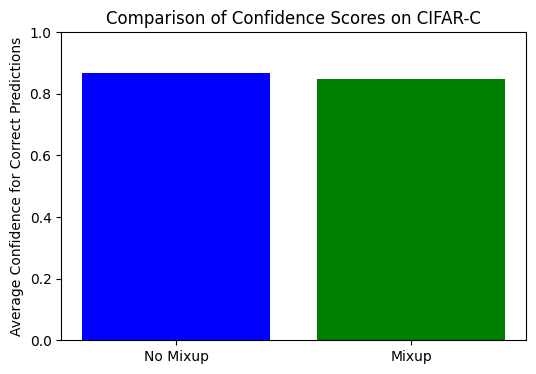

Average confidence (No Mixup): 0.868
Average confidence (Mixup): 0.850


In [ ]:
# Plot the confidence scores for CIFAR-C with WRN model
# trained with and without mixup and comment

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import random

# First, define a function to compute the average confidence for correct predictions
# over the CIFAR-C dataset (using a 1000-sample subset per corruption)

def compute_avg_confidence(net, batch_size=32):
    # Base path: update {PATH_TO_WORK_FOLDER} with the correct folder path.
    base_path = '/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/data/cifar/CIFAR-10-C/'
    normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    all_confidences = []  # will store confidence scores for correct predictions

    # Iterate over each corruption type
    for corruption in CORRUPTIONS:
        # Load corruption data and labels (take the last 10000 entries as in previous code)
        corrupt_data = np.load(base_path + corruption + '.npy')[-10000:]
        corrupt_labels = np.load(base_path + 'labels.npy')[-10000:]

        # Select a random subset of 1000 samples
        subset_size = 1000
        selected_indices = np.random.choice(len(corrupt_data), subset_size, replace=False)
        subset_data = corrupt_data[selected_indices]
        subset_labels = corrupt_labels[selected_indices]

        # Apply transform to each image in the subset.
        # Each image in CIFAR is stored as a HWC numpy array.
        transformed_imgs = []
        for img in subset_data:
            # The transform expects a PIL image; however, ToTensor can also convert a numpy array if in [0,255]
            # Normalize expects values in [0,1], so we convert accordingly.
            # Convert to float and scale
            img = img.astype(np.uint8)
            transformed_imgs.append(test_transform(img))
        # Stack into a tensor
        images_tensor = torch.stack(transformed_imgs)
        labels_tensor = torch.tensor(subset_labels, dtype=torch.long)

        # Move data to device
        images_tensor = images_tensor.to(device)
        labels_tensor = labels_tensor.to(device)

        # Forward pass through the model
        with torch.no_grad():
            outputs = net(images_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probabilities, dim=1)
            # For each sample where prediction is correct, store the confidence (probability for the true class)
            for i in range(len(labels_tensor)):
                if preds[i] == labels_tensor[i]:
                    all_confidences.append(probabilities[i][labels_tensor[i]].item())

    if len(all_confidences) == 0:
        return 0.0
    return np.mean(all_confidences)

# Now, load the best WRN-16-8 models for both cases: without mixup and with mixup.
# Replace the file paths with the correct ones if needed.

# Model without mixup
model_no_mixup = WideResNet(16, 10, 8, 0.0)
model_no_mixup.load_state_dict(torch.load("/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/runs/cifar-c-10_nomixup/best/checkpoint.pth.tar"))
model_no_mixup = model_no_mixup.to(device)
model_no_mixup.eval()
avg_conf_no_mixup = compute_avg_confidence(model_no_mixup)

# Model with mixup
model_mixup = WideResNet(16, 10, 8, 0.0)
model_mixup.load_state_dict(torch.load("/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/runs/cifar-c-10_mixup/best/checkpoint.pth.tar"))
model_mixup = model_mixup.to(device)
model_mixup.eval()
avg_conf_mixup = compute_avg_confidence(model_mixup)

# Plotting the average confidence scores
labels_plot = ['No Mixup', 'Mixup']
confidences = [avg_conf_no_mixup, avg_conf_mixup]

plt.figure(figsize=(6,4))
plt.bar(labels_plot, confidences, color=['blue', 'green'])
plt.ylabel('Average Confidence for Correct Predictions')
plt.title('Comparison of Confidence Scores on CIFAR-C')
plt.ylim(0,1)
plt.show()

print("Average confidence (No Mixup): {:.3f}".format(avg_conf_no_mixup))
print("Average confidence (Mixup): {:.3f}".format(avg_conf_mixup))


Average Confidence per Class (No Mixup):
Class 0: 0.844
Class 1: 0.851
Class 2: 0.830
Class 3: 0.897
Class 4: 0.871
Class 5: 0.847
Class 6: 0.901
Class 7: 0.865
Class 8: 0.869
Class 9: 0.895

Average Confidence per Class (Mixup):
Class 0: 0.857
Class 1: 0.858
Class 2: 0.822
Class 3: 0.779
Class 4: 0.843
Class 5: 0.845
Class 6: 0.882
Class 7: 0.839
Class 8: 0.852
Class 9: 0.904


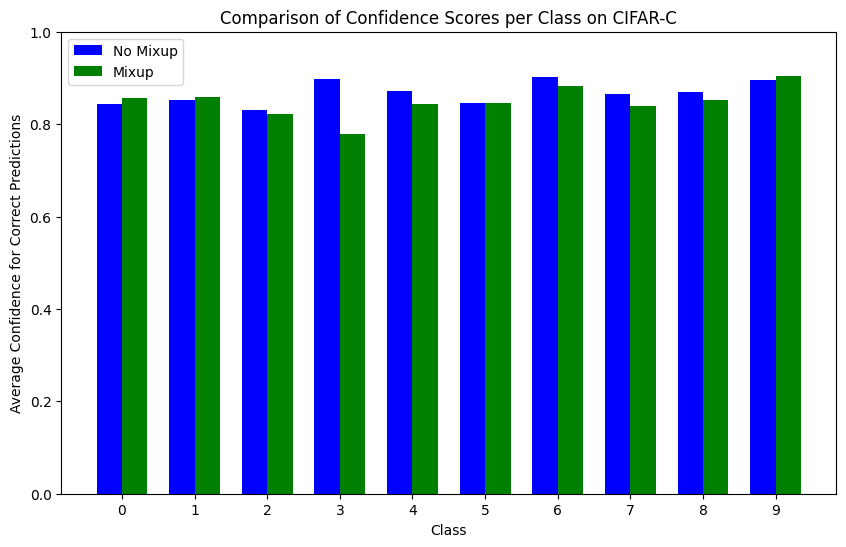

In [ ]:
def compute_confidence_per_class(net, batch_size=32):
    # Base path: update with the correct folder path.
    base_path = '/content/drive/My Drive/Lab_DL_ex1_v2/Lab_DL_ex1/data/cifar/CIFAR-10-C/'
    normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    # Dictionary to hold confidence scores for correct predictions per class (0 to 9)
    confidences_per_class = {i: [] for i in range(10)}

    # Iterate over each corruption type defined in CORRUPTIONS
    for corruption in CORRUPTIONS:
        # Load corruption data and labels (take the last 10000 entries)
        corrupt_data = np.load(base_path + corruption + '.npy')[-10000:]
        corrupt_labels = np.load(base_path + 'labels.npy')[-10000:]

        # Select a random subset of 1000 samples
        subset_size = 1000
        selected_indices = np.random.choice(len(corrupt_data), subset_size, replace=False)
        subset_data = corrupt_data[selected_indices]
        subset_labels = corrupt_labels[selected_indices]

        # Apply transform to each image in the subset
        transformed_imgs = []
        for img in subset_data:
            img = img.astype(np.uint8)
            transformed_imgs.append(test_transform(img))
        images_tensor = torch.stack(transformed_imgs)
        labels_tensor = torch.tensor(subset_labels, dtype=torch.long)

        # Move data to device
        images_tensor = images_tensor.to(device)
        labels_tensor = labels_tensor.to(device)

        # Forward pass through the model
        with torch.no_grad():
            outputs = net(images_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probabilities, dim=1)
            # For each sample where prediction is correct, store the confidence for the true class
            for i in range(len(labels_tensor)):
                if preds[i] == labels_tensor[i]:
                    confidences_per_class[labels_tensor[i].item()].append(probabilities[i][labels_tensor[i]].item())

    # Compute average confidence per class
    avg_confidences = {}
    for cls in range(10):
        if len(confidences_per_class[cls]) > 0:
            avg_confidences[cls] = np.mean(confidences_per_class[cls])
        else:
            avg_confidences[cls] = 0.0
    return avg_confidences

# Compute per-class average confidence scores for both models

# For the model without mixup (assume model_no_mixup is already loaded and set to eval mode)
avg_conf_no_mixup_per_class = compute_confidence_per_class(model_no_mixup)

# For the model with mixup (assume model_mixup is already loaded and set to eval mode)
avg_conf_mixup_per_class = compute_confidence_per_class(model_mixup)

# Print the per-class average confidence scores
print("Average Confidence per Class (No Mixup):")
for cls in sorted(avg_conf_no_mixup_per_class.keys()):
    print("Class {}: {:.3f}".format(cls, avg_conf_no_mixup_per_class[cls]))

print("\nAverage Confidence per Class (Mixup):")
for cls in sorted(avg_conf_mixup_per_class.keys()):
    print("Class {}: {:.3f}".format(cls, avg_conf_mixup_per_class[cls]))

# Plot bar charts comparing the per-class confidences for both models
classes = list(range(10))
conf_no_mix = [avg_conf_no_mixup_per_class[c] for c in classes]
conf_mix = [avg_conf_mixup_per_class[c] for c in classes]

x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, conf_no_mix, width, label='No Mixup', color='blue')
plt.bar(x + width/2, conf_mix, width, label='Mixup', color='green')
plt.xlabel('Class')
plt.ylabel('Average Confidence for Correct Predictions')
plt.title('Comparison of Confidence Scores per Class on CIFAR-C')
plt.xticks(x, classes)
plt.ylim(0, 1)
plt.legend()
plt.show()
